# 1. BiLSTM을 텍스트 분류에 사용하기

# 2. Mecab 설치

In [14]:
!python -V

Python 3.8.12


In [40]:
from konlpy.tag import Mecab
mecab = Mecab('C:\mecab\mecab-ko-dic')
mecab.morphs('안녕하세요 오늘 날씨가 좋네요')

['안녕', '하', '세요', '오늘', '날씨', '가', '좋', '네요']

# 3. 스팀 리뷰 데이터에 대한 이해와 전처리

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from collections import Counter
from konlpy.tag import Mecab
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 워닝 무시
import warnings
warnings.filterwarnings('ignore')

## 1) 데이터 로드하기

In [4]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/bab2min/corpus/master/sentiment/steam.txt", filename="steam.txt")

('steam.txt', <http.client.HTTPMessage at 0x13bcb90e550>)

In [6]:
total_data = pd.read_table('steam.txt', names=['label', 'reviews'])

print('전체 리뷰 개수 :',len(total_data)) # 전체 리뷰 개수 출력
total_data.head()

전체 리뷰 개수 : 100000


,label,reviews
0,0,노래가 너무 적음
1,0,"돌겠네 진짜. 황숙아, 어크 공장 그만 돌려라. 죽는다."
2,1,막노동 체험판 막노동 하는사람인데 장비를 내가 사야돼 뭐지
3,1,차악!차악!!차악!!! 정말 이래서 왕국을 되찾을 수 있는거야??
4,1,시간 때우기에 좋음.. 도전과제는 50시간이면 다 깰 수 있어요


In [9]:
total_data['reviews'].nunique()

99892

In [10]:
total_data['label'].nunique()

2

In [8]:
total_data.drop_duplicates(subset=['reviews'], inplace=True) # reviews 열에서 중복인 내용이 있다면 중복 제거
print('총 샘플의 수 :',len(total_data))

총 샘플의 수 : 99892


In [11]:
print(total_data.isnull().values.any())

False


## 2) 훈련 데이터와 테스트 데이터 분리하기

In [12]:
train_data, test_data = train_test_split(total_data, test_size = 0.25, random_state = 42)
print('훈련용 리뷰의 개수 :', len(train_data))
print('테스트용 리뷰의 개수 :', len(test_data))

훈련용 리뷰의 개수 : 74919
테스트용 리뷰의 개수 : 24973


## 3) 레이블의 분포 확인

<AxesSubplot:>

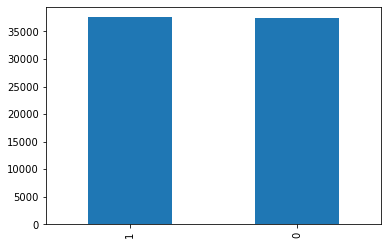

In [15]:
train_data['label'].value_counts().plot(kind = 'bar')

In [19]:
print(train_data.groupby('label').size().reset_index(name = 'count'))

   label  count
0      0  37376
1      1  37543


## 4) 데이터 정제하기

In [21]:
# 한글과 공백을 제외하고 모두 제거
train_data['reviews'] = train_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data['reviews'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

label      0
reviews    0
dtype: int64


C:\Users\student\AppData\Local\Temp/ipykernel_15220/3212377984.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['reviews'] = train_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
C:\Users\student\AppData\Local\Temp/ipykernel_15220/3212377984.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['reviews'] = train_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


In [22]:
test_data.drop_duplicates(subset = ['reviews'], inplace=True) # 중복 제거
test_data['reviews'] = test_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data['reviews'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 24973


C:\ProgramData\Anaconda3\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
C:\Users\student\AppData\Local\Temp/ipykernel_15220/1476265803.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['reviews'] = test_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
C:\Users\student\AppData\Local\Temp/ipykernel_15220/1476265803.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['reviews'] = test_data['reviews'].str.rep

In [24]:
stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게', '만', '게임', '겜', '되', '음', '면']

## 5) 토큰화

In [42]:
from konlpy.tag import Mecab
mecab = Mecab('C:\mecab\mecab-ko-dic')

train_data['tokenized'] = train_data['reviews'].apply(mecab.morphs)
train_data['tokenized'] = train_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])
test_data['tokenized'] = test_data['reviews'].apply(mecab.morphs)
test_data['tokenized'] = test_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

## 6) 단어와 길이 분포 확인하기

In [43]:
negative_words = np.hstack(train_data[train_data.label == 0]['tokenized'].values)
positive_words = np.hstack(train_data[train_data.label == 1]['tokenized'].values)

In [44]:
negative_word_count = Counter(negative_words)
print(negative_word_count.most_common(20))

[('안', 8129), ('없', 7141), ('는데', 5786), ('있', 5692), ('같', 4247), ('로', 4083), ('할', 3920), ('거', 3902), ('나', 3805), ('해', 3653), ('너무', 3522), ('으로', 3351), ('기', 3348), ('했', 3265), ('어', 3143), ('보', 2987), ('습니다', 2962), ('것', 2935), ('지만', 2911), ('좋', 2899)]


In [45]:
positive_word_count = Counter(positive_words)
print(positive_word_count.most_common(20))

[('있', 9987), ('좋', 6542), ('습니다', 5179), ('재밌', 4997), ('할', 4838), ('지만', 4809), ('해', 4354), ('없', 4145), ('보', 3907), ('으로', 3900), ('로', 3879), ('수', 3835), ('는데', 3825), ('기', 3592), ('안', 3368), ('것', 3362), ('같', 3356), ('네요', 3189), ('어', 3112), ('나', 3055)]


긍정 리뷰의 평균 길이 : 14.948459100231734
부정 리뷰의 평균 길이 : 15.284193065068493


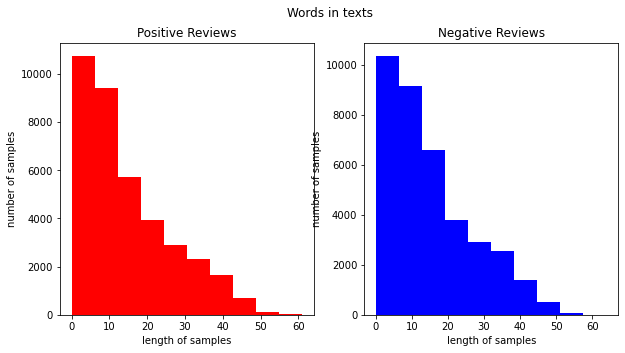

In [46]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
text_len = train_data[train_data['label']==1]['tokenized'].map(lambda x: len(x))
ax1.hist(text_len, color='red')
ax1.set_title('Positive Reviews')
ax1.set_xlabel('length of samples')
ax1.set_ylabel('number of samples')
print('긍정 리뷰의 평균 길이 :', np.mean(text_len))

text_len = train_data[train_data['label']==0]['tokenized'].map(lambda x: len(x))
ax2.hist(text_len, color='blue')
ax2.set_title('Negative Reviews')
fig.suptitle('Words in texts')
ax2.set_xlabel('length of samples')
ax2.set_ylabel('number of samples')
print('부정 리뷰의 평균 길이 :', np.mean(text_len))
plt.show()

In [47]:
X_train = train_data['tokenized'].values
y_train = train_data['label'].values
X_test= test_data['tokenized'].values
y_test = test_data['label'].values

## 7) 정수 인코딩

In [48]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [50]:
tokenizer.word_index

{'있': 1,
 '안': 2,
 '없': 3,
 '는데': 4,
 '좋': 5,
 '할': 6,
 '습니다': 7,
 '해': 8,
 '로': 9,
 '지만': 10,
 '같': 11,
 '으로': 12,
 '기': 13,
 '보': 14,
 '나': 15,
 '거': 16,
 '재밌': 17,
 '것': 18,
 '했': 19,
 '어': 20,
 '수': 21,
 '네요': 22,
 '너무': 23,
 '아': 24,
 '않': 25,
 '적': 26,
 '플레이': 27,
 '좀': 28,
 '었': 29,
 '겠': 30,
 '시간': 31,
 '에서': 32,
 '사': 33,
 '때': 34,
 '주': 35,
 '함': 36,
 '입니다': 37,
 '재미': 38,
 '사람': 39,
 '아니': 40,
 '개': 41,
 '더': 42,
 '추천': 43,
 '내': 44,
 '서': 45,
 '잘': 46,
 '스토리': 47,
 '재미있': 48,
 '라': 49,
 '그냥': 50,
 '합니다': 51,
 '생각': 52,
 '왜': 53,
 '말': 54,
 '았': 55,
 '못': 56,
 '시': 57,
 '보다': 58,
 '해서': 59,
 '많': 60,
 '잼': 61,
 '으면': 62,
 '한글': 63,
 '갓': 64,
 '어서': 65,
 '싶': 66,
 '진짜': 67,
 '분': 68,
 '정말': 69,
 '그': 70,
 '모르': 71,
 '이거': 72,
 '돈': 73,
 '버그': 74,
 '만들': 75,
 '그래픽': 76,
 '던': 77,
 '번': 78,
 '세요': 79,
 '정도': 80,
 '면서': 81,
 '감': 82,
 '뭐': 83,
 '화': 84,
 '니': 85,
 '까지': 86,
 '원': 87,
 '중': 88,
 '다가': 89,
 '어요': 90,
 '긴': 91,
 '야': 92,
 '멀티': 93,
 '라고': 94,
 '친구': 95,
 '건': 96,
 

In [51]:
threshold = 2
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 32817
등장 빈도가 1번 이하인 희귀 단어의 수: 13878
단어 집합에서 희귀 단어의 비율: 42.28905750068562
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.2254607619437832


In [52]:
# 전체 단어 개수 중 빈도수 2이하인 단어 개수는 제거.
# 0번 패딩 토큰과 1번 OOV 토큰을 고려하여 +2
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 18941


In [53]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [54]:
print(X_train[:3])

[[495, 7, 35, 87, 149, 2429, 599, 26, 8, 70, 47, 235, 111, 38, 44, 52], [161, 300, 18, 20, 63, 3582, 985, 6, 56], [7, 17, 1476, 4]]


In [55]:
print(X_test[:3])

[[728, 34, 16, 431, 52, 106, 132, 99, 6461, 453], [4527, 687, 835, 712, 792, 108, 4, 1779, 95, 370, 3518, 81, 558, 1904, 4189, 262, 169, 61, 25, 363, 35, 87, 974, 19, 6294, 6422], [1792, 806, 685, 49, 23, 349]]


## 8) 패딩

리뷰의 최대 길이 : 64
리뷰의 평균 길이 : 15.115951894712957


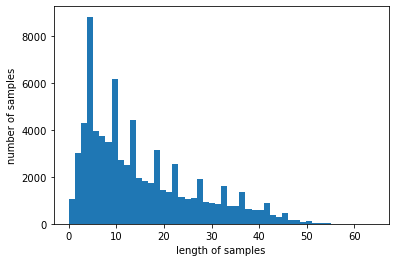

In [56]:
print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [58]:
def below_threshold_len(max_len, nested_list):
    count = 0
    for sentence in nested_list:
        if(len(sentence) <= max_len):
            count = count + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [59]:
max_len = 60
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 60 이하인 샘플의 비율: 99.99599567532935


In [60]:
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

# 4. BiLSTM으로 스팀 리뷰 감성 분류하기

In [61]:
import re
from tensorflow.keras.layers import Embedding, Dense, LSTM, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(Bidirectional(LSTM(hidden_units))) # Bidirectional LSTM을 사용
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=256, validation_split=0.2)

Epoch 1/15
234/235 [============================>.] - ETA: 0s - loss: 0.5300 - acc: 0.7408
Epoch 1: val_acc improved from -inf to 0.77516, saving model to best_model.h5
235/235 [==============================] - 49s 199ms/step - loss: 0.5300 - acc: 0.7408 - val_loss: 0.4777 - val_acc: 0.7752
Epoch 2/15
235/235 [==============================] - ETA: 0s - loss: 0.4329 - acc: 0.8024
Epoch 2: val_acc improved from 0.77516 to 0.78444, saving model to best_model.h5
235/235 [==============================] - 48s 204ms/step - loss: 0.4329 - acc: 0.8024 - val_loss: 0.4680 - val_acc: 0.7844
Epoch 3/15
235/235 [==============================] - ETA: 0s - loss: 0.4074 - acc: 0.8182
Epoch 3: val_acc did not improve from 0.78444
235/235 [==============================] - 47s 199ms/step - loss: 0.4074 - acc: 0.8182 - val_loss: 0.4700 - val_acc: 0.7826
Epoch 4/15
235/235 [==============================] - ETA: 0s - loss: 0.3880 - acc: 0.8285
Epoch 4: val_acc did not improve from 0.78444
235/235 [====

In [62]:
loaded_model = load_model('best_model.h5')
print("테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

781/781 [==============================] - 9s 10ms/step - loss: 0.5148 - acc: 0.7854
테스트 정확도: 0.7854


# 5. 리뷰 예측해보기

In [63]:
def sentiment_predict(new_sentence):
    new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
    new_sentence = mecab.morphs(new_sentence) # 토큰화
    new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
    encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
    pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
    score = float(loaded_model.predict(pad_new)) # 예측
    if(score > 0.5):
        print("{:.2f}% 확률로 긍정 리뷰입니다.".format(score * 100))
    else:
        print("{:.2f}% 확률로 부정 리뷰입니다.".format((1 - score) * 100))

In [64]:
sentiment_predict('노잼 ..완전 재미 없음 ㅉㅉ')

1/1 [==============================] - 1s 547ms/step
98.07% 확률로 부정 리뷰입니다.


In [65]:
sentiment_predict('조금 어렵지만 재밌음ㅋㅋ')

1/1 [==============================] - 0s 15ms/step
98.15% 확률로 긍정 리뷰입니다.


In [66]:
sentiment_predict('케릭터가 예뻐서 좋아요')

1/1 [==============================] - 0s 17ms/step
95.95% 확률로 긍정 리뷰입니다.
